In [15]:
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from os import listdir
from random import randint
from sklearn.model_selection import train_test_split
from time import time
from copy import deepcopy
from torch import nn

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [17]:
!pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset'
od.download(dataset_url)

Skipping, found downloaded files in "./breast-ultrasound-images-dataset" (use force=True to force download)


In [18]:
data_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

In [19]:
def load_dir(dir):
    images = []
    masks = []
    for subdir in listdir(dir):
        for file in listdir(f"{dir}/{subdir}"):
            if file.endswith(".png") and "mask" not in file:
                image = imread(f"{dir}/{subdir}/{file}")
                image = resize(image, output_shape=(128,128))
                image = rgb2gray(image)
                
                filename = file.split(".")[0]
                files_list = list(Path(f"{dir}/{subdir}").rglob(f"{filename}*"))
                masks_list = [f for f in files_list if "mask" in str(f)]

                if len(masks_list) == 1:
                        mask_file = masks_list[0]
                        mask = imread(f"{mask_file}")
                        mask = resize(mask, output_shape=(128, 128))
                        mask = rgb2gray(mask)
                                                
                        images.append(image)
                        masks.append(mask)
                        
                else:
                    continue

                
    return np.array(images), np.array(masks)

In [20]:
images, masks = load_dir(data_dir)
print(f"Images shape: {images.shape}",
      f"Masks shape: {masks.shape}\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


Images shape: (763, 128, 128) Masks shape: (763, 128, 128)



In [21]:
def flip(images, labels, axis):
    flipped_images = np.flip(images, axis)
    flipped_labels = np.flip(labels, axis)
    return flipped_images, flipped_labels

def augmentation(images, labels):
    flipped_y_images, flipped_y_labels = flip(images, labels, axis=2)
    images = np.concatenate([images, flipped_y_images])
    labels = np.concatenate([labels, flipped_y_labels])

    flipped_x_images, flipped_x_labels = flip(images, labels, axis=1)
    images = np.concatenate([images, flipped_x_images])
    labels = np.concatenate([labels, flipped_x_labels])
    return images, labels

images, masks = augmentation(images, masks)
print(f"Images shape: {images.shape}",
      f"Masks shape: {masks.shape}\n")

Images shape: (3052, 128, 128) Masks shape: (3052, 128, 128)



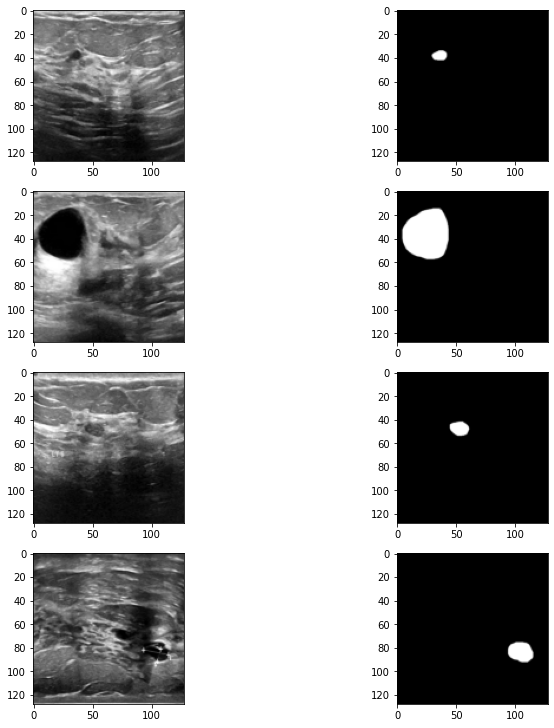

In [22]:
f, axis = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(10, 10))
for i in range(4):
    rand = randint(0, images.shape[0]-1)
    axis[i, 0].imshow(images[rand], cmap="gray")
    axis[i, 1].imshow(masks[rand], cmap="gray")
plt.show()

In [23]:
images = np.expand_dims(images, axis=3)
masks = np.expand_dims(masks, axis=3)


x_train, x_val, y_train, y_val = train_test_split(images, masks,
                                                  test_size= 0.2,
                                                  shuffle=True,
                                                  random_state=2021)

x_test, x_val, y_test, y_val = train_test_split(x_val, y_val,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=2021)

print(f"Train arrays shape: {x_train.shape}, {y_train.shape}")
print(f"Test arrays shape: {x_test.shape}, {y_test.shape}")
print(f"Validation arrays shape: {x_val.shape}, {y_val.shape}")

Train arrays shape: (2441, 128, 128, 1), (2441, 128, 128, 1)
Test arrays shape: (305, 128, 128, 1), (305, 128, 128, 1)
Validation arrays shape: (306, 128, 128, 1), (306, 128, 128, 1)


In [24]:
images_format = torch.float32
masks_format = torch.float32

# Free memory
del images, masks

# Convert Numpy arrays to Torch tensors
train_inputs = torch.from_numpy(x_train).to(images_format).to(device)
train_outputs = torch.from_numpy(y_train).to(masks_format).to(device)
del x_train, y_train

val_inputs = torch.from_numpy(x_val).to(images_format).to(device)
val_outputs = torch.from_numpy(y_val).to(masks_format).to(device)
del x_val, y_val

test_inputs = torch.from_numpy(x_test).to(images_format).to(device)
test_outputs = torch.from_numpy(y_test).to(masks_format).to(device)
del x_test, y_test

train_inputs = train_inputs.permute(0, 3, 1, 2)
val_inputs = val_inputs.permute(0, 3, 1, 2)
test_inputs = test_inputs.permute(0, 3, 1, 2)

train_outputs = train_outputs.permute(0, 3, 1, 2)
val_outputs = val_outputs.permute(0, 3, 1, 2)
test_outputs = test_outputs.permute(0, 3, 1, 2)



# Verify datasets shapes
print(f"Train tensor shape: {train_inputs.shape}, {train_outputs.shape}")
print(f"Test tensor shape: {test_inputs.shape}, {test_outputs.shape}")
print(f"Validation tensor shape: {val_inputs.shape}, {val_outputs.shape}")

Train tensor shape: torch.Size([2441, 1, 128, 128]), torch.Size([2441, 1, 128, 128])
Test tensor shape: torch.Size([305, 1, 128, 128]), torch.Size([305, 1, 128, 128])
Validation tensor shape: torch.Size([306, 1, 128, 128]), torch.Size([306, 1, 128, 128])


In [25]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.AvgPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)
        x = self.conv(a)
        return x


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = double_conv(1, 8)
        self.down1 = down_layer(8, 16)
        self.down2 = down_layer(16, 32)
        self.down3 = down_layer(32, 64)
        self.down4 = down_layer(64, 128)
        self.down5 = down_layer(128, 256)
        self.down6 = down_layer(256, 512)
        self.down7 = down_layer(512, 1024)
        
        self.up1 = up_layer(1024, 512)
        self.up2 = up_layer(512, 256)
        self.up3 = up_layer(256, 128)
        self.up4 = up_layer(128, 64)
        self.up5 = up_layer(64, 32)
        self.up6 = up_layer(32, 16)
        self.up7 = up_layer(16, 8)
        self.last_conv = nn.Conv2d(8, 1, 1)
        self.dilute = nn.Conv2d(1, 1, 1)


    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x7 = self.down6(x6)
        x8 = self.down7(x7)
        
        x1_up = self.up1(x7, x8)
        x2_up = self.up2(x6, x1_up)
        x3_up = self.up3(x5, x2_up)
        x4_up = self.up4(x4, x3_up)
        x5_up = self.up5(x3, x4_up)
        x6_up = self.up6(x2, x5_up)
        x7_up = self.up7(x1, x6_up)
    
        output = self.last_conv(x7_up)
        output = self.dilute(output)
        output = torch.sigmoid(output)
        return output

In [26]:
net = UNet().to(device)
optim = torch.optim.Adam(net.parameters(), lr=1.0E-3)

In [27]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):    
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

    
net = UNet().to(device)
optim = torch.optim.Adam(net.parameters(), lr=1.0E-3)
criterion = DiceLoss()

In [28]:
best_loss = np.inf
epochs = 200
patience = 5
batch_size = 32
train_losses = []
val_losses = []
achieved_epochs = []
total_train = train_inputs.size()[0]
total_val = val_inputs.size()[0]
print("Train loop:\n")

t0 = time()
for epoch in range(epochs):
    net.train()
    train_loss = 0
    val_loss = 0
    achieved_epochs.append(epoch)
    train_permutation = torch.randperm(total_train)
    val_permutation = torch.randperm(total_val)

    for i in range(0, total_train, batch_size):
        optim.zero_grad()
        indices = train_permutation[i:i+batch_size]
        batch_x, batch_y = train_inputs[indices], train_outputs[indices]
        outputs = net(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optim.step()
        train_loss += loss
    train_loss = train_loss.cpu().detach() / total_train
    train_losses.append(train_loss)

    for j in range(0, total_val, batch_size):
        net.eval()
        indices = val_permutation[j:j+batch_size]
        batch_x, batch_y = val_inputs[indices], val_outputs[indices]
        outputs = net(batch_x)
        loss = criterion(outputs, batch_y)
        
        val_loss += loss
    val_loss = val_loss.cpu().detach() / total_val
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        cost_patience = patience
        state_dict = deepcopy(net.state_dict())
        print(f"\tEpoch: {epoch+1}/{epochs}, ",
              f"Train Loss: {train_loss:.3g}, ",
              f"Val Loss: {val_loss:.3g}")

    else:
        cost_patience -= 1
        if cost_patience < 0:
            print(f"\nEarly stopping after {patience} epochs of no improvements")
            break

        else:
            print(f"\tEpoch: {epoch+1}/{epochs}, ",
                  f"Train Loss: {train_loss:.3g}, ",
                  f"Val Loss: {val_loss:.3g} - No improvement",
                  f"-> Remaining patience: {cost_patience}")

tf = time()
print(f"\nTrain finished successfully in {tf-t0:.3g}s")

Train loop:

	Epoch: 1/200,  Train Loss: 0.0271,  Val Loss: 0.0272
	Epoch: 2/200,  Train Loss: 0.026,  Val Loss: 0.0263
	Epoch: 3/200,  Train Loss: 0.0238,  Val Loss: 0.0241
	Epoch: 4/200,  Train Loss: 0.0204,  Val Loss: 0.0202
	Epoch: 5/200,  Train Loss: 0.016,  Val Loss: 0.0203 - No improvement -> Remaining patience: 4
	Epoch: 6/200,  Train Loss: 0.0123,  Val Loss: 0.0144
	Epoch: 7/200,  Train Loss: 0.00962,  Val Loss: 0.0102
	Epoch: 8/200,  Train Loss: 0.00845,  Val Loss: 0.0109 - No improvement -> Remaining patience: 4
	Epoch: 9/200,  Train Loss: 0.00786,  Val Loss: 0.00909
	Epoch: 10/200,  Train Loss: 0.00754,  Val Loss: 0.0101 - No improvement -> Remaining patience: 4
	Epoch: 11/200,  Train Loss: 0.00714,  Val Loss: 0.00811
	Epoch: 12/200,  Train Loss: 0.00675,  Val Loss: 0.00826 - No improvement -> Remaining patience: 4
	Epoch: 13/200,  Train Loss: 0.00655,  Val Loss: 0.00812 - No improvement -> Remaining patience: 3
	Epoch: 14/200,  Train Loss: 0.00632,  Val Loss: 0.00721
	Epoc

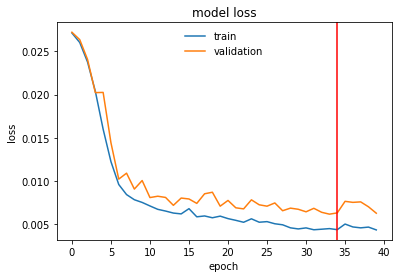

In [29]:
f, ax = plt.subplots()
ax.plot(achieved_epochs, train_losses, label='train')
ax.plot(achieved_epochs, val_losses, label='validation')
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
no_improvement_line = achieved_epochs[-1] - patience
ax.axvline(x=no_improvement_line, color='r')
ax.legend(loc='upper center', frameon=False)
plt.show()

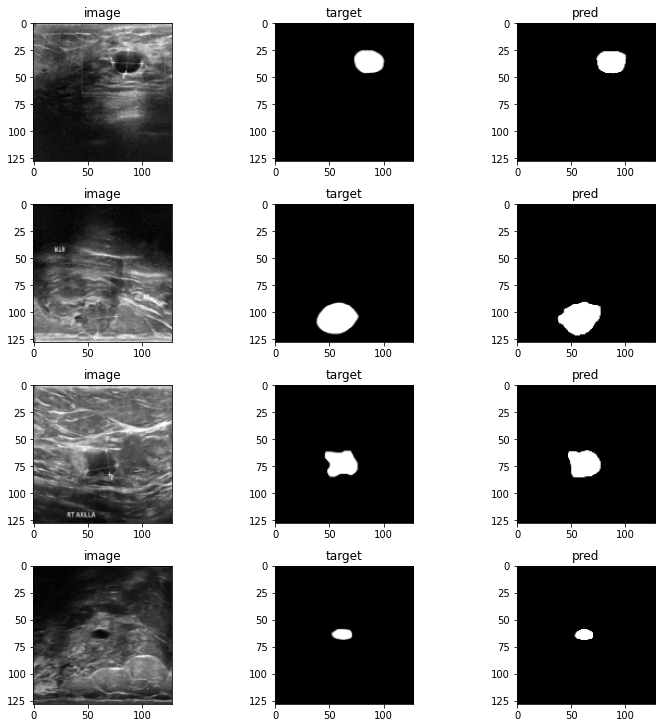

In [30]:
predictions = net(test_inputs).cpu().detach().numpy()
images = test_inputs.cpu().detach().numpy()
masks = test_outputs.cpu().detach().numpy()

f, axis = plt.subplots(nrows=4, ncols=3, constrained_layout=True, figsize=(10, 10))
for i in range(4):
    rand = randint(0, images.shape[0]-1)
    axis[i, 0].imshow(images[rand][0], cmap="gray")
    axis[i, 0].set_title("image")
    axis[i, 1].imshow(masks[rand][0], cmap="gray")
    axis[i, 1].set_title("target")
    axis[i, 2].imshow(predictions[rand][0], cmap="gray")
    axis[i, 2].set_title("pred")

plt.show()

In [31]:
torch.save(state_dict, "./checkpoint.pth")
print("\nCheckpoint saved successfully :)")


Checkpoint saved successfully :)
